In [1]:
import json
import requests
import pandas as pd
import numpy as np
import networkx as nx
import nxpd
import matplotlib.pyplot as plt
import matplotlib
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import dataframe
import graphframes


from src.data_reader import DataReader, RetractionFinder
from src.to_gexf import to_gexf
from src.get_redacted import get_paper, load_redacted, get_doi, gen_retracted
import src.load_data as load_data

In [11]:
df_full = load_data.load_dataframe(source='data/retracted_articles', limit=-1)
df = load_data.format_dataframe(df_full)

# EDA

In [12]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [13]:
X,y = df.loc[:, ['numInCitations','numAuthors', 'numEntities', 'year', 'pageLength']], df['retracted']
X,y = df.drop('retracted', axis=1), df['retracted']
X0,Xt,y0,yt = train_test_split(X,y)

In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', 
                            max_depth=2, n_jobs=-1, n_estimators=1000,
                            random_state=5476)
gbc = GradientBoostingClassifier(max_features='sqrt',
                                 max_depth=2, n_estimators=1000,
                                 random_state=5476)

rf.fit(numeric(X0), y0)
gbc.fit(numeric(X0), y0)

In [ ]:
print(log_loss(y_pred=rf.predict_proba(numeric(Xt))[:,1], y_true=yt))
print(log_loss(y_pred=gbc.predict_proba(numeric(Xt))[:,1], y_true=yt))

In [ ]:
fpr, tpr, thr = roc_curve(y_score=gbc.predict_proba(numeric(Xt))[:,1], y_true=yt)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7))
ax0.plot(fpr, tpr)
ax1.bar(x=numeric(X).columns, height=gbc.feature_importances_)

In [47]:
def plot_proportions(X, y, lbl):
    xx, yy = [], []
    for val in np.unique(X[lbl]):
        xx.append(val)
        y_hat = y[X[lbl] == val]
        yy.append(y_hat.sum()/len(y_hat))
    return xx,yy

def plot_feature(ax, X, y, col):
    ax.scatter(X[col], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
    ax.plot(*plot_proportions(X,y, col), c='orange')
    ax.set_title(label=col)

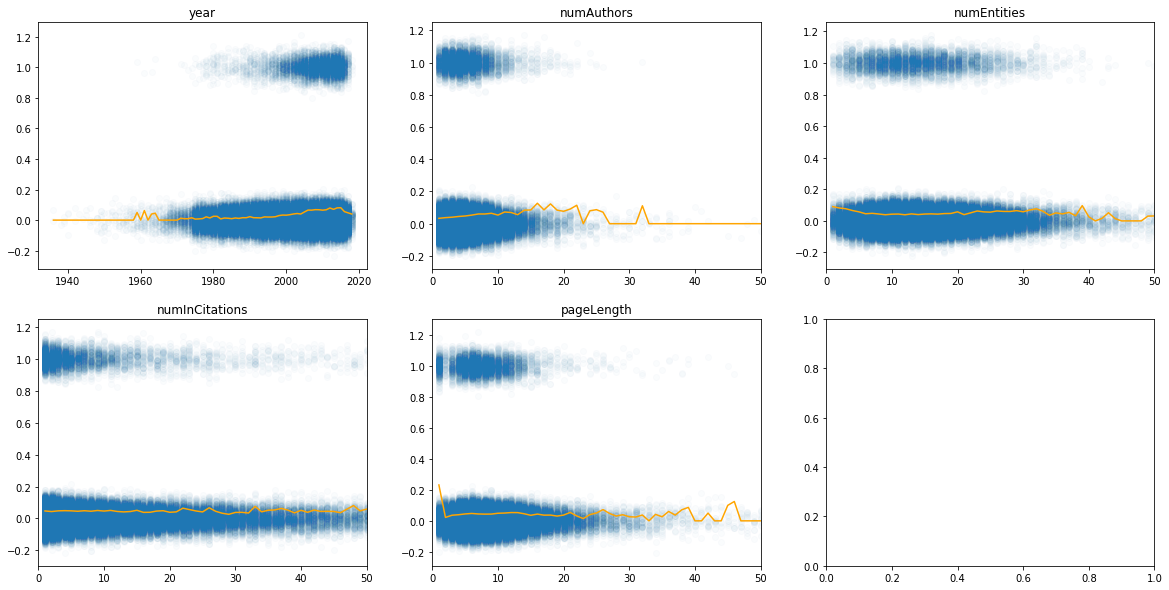

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
for i, (ax, col) in enumerate(zip(axs.flatten(), ('year', 'numAuthors', 'numEntities', 
                                   'numInCitations', 'pageLength'))):
    plot_feature(ax, X, y, col)
    if i != 0:
        ax.set_xlim(left=0, right=50)


In [ ]:
has_p_value = df_full['paperAbstract'].apply(lambda x: any(p in x.lower() for p in ('pvalue','p-value', 'p value')))

In [ ]:
print(len(df_full['paperAbstract'][has_p_value & df['retracted']]), sum(df['retracted']))
print(len(df_full['paperAbstract'][has_p_value & df['retracted']])/sum(df['retracted']))
print(np.std([has_p_value & df['retracted']]))

In [ ]:
print(len(df_full['paperAbstract'][has_p_value & ~df['retracted']]), sum(~df['retracted']))
print(len(df_full['paperAbstract'][has_p_value & ~df['retracted']])/sum(~df['retracted']))
print(np.std([has_p_value & ~df['retracted']]))

In [ ]:
abstract_tfidf = TfidfVectorizer()
abstract_tfidf.fit(X0['paperAbstract'].apply(lambda x: x.lower().replace('withdraw', '').replace('retract', '')))
abstract_train = abstract_tfidf.transform(X0['paperAbstract'])
abstract_test = abstract_tfidf.transform(Xt['paperAbstract'])

abstract_bayes = MultinomialNB()
abstract_bayes.fit(abstract_train, y0)
log_loss(y_pred=abstract_bayes.predict_proba(abstract_test)[:,1], y_true=yt)

In [ ]:
title_tfidf = TfidfVectorizer()
title_tfidf.fit(X0['title'].apply(lambda x: x.lower().replace('withdraw', '').replace('retract', '')))
title_train = title_tfidf.transform(X0['title'])
title_test = title_tfidf.transform(Xt['title'])


title_bayes = MultinomialNB()
title_bayes.fit(title_train, y0)
log_loss(y_pred=title_bayes.predict_proba(title_test)[:,1], y_true=yt)

In [ ]:
np.array(list(title_tfidf.vocabulary_.keys()))[np.argsort(title_bayes.coef_)][0, -5:]

# Export to Graph File

In [10]:
reader = DataReader('data/retracted_articles')
reader.write(lim=10000, dynamic=True)

In [11]:
edges = spark.createDataFrame(reader.read_edges(), schema=StructType(
[
    StructField(name='src', dataType=StringType()),
    StructField(name='dst', dataType=StringType()),
    StructField(name='year', dataType=StringType())
]
)).withColumn('id', F.monotonically_increasing_id())


nodes = spark.createDataFrame(reader.read_nodes(), schema=StructType(
[
    StructField(name='id', dataType=StringType()),
    StructField(name='year', dataType=StringType()),
    StructField(name='authors', dataType=StringType())
]
))

In [12]:
g = graphframes.GraphFrame(e=edges, v=nodes)
to_gexf(g, 'data/graph.gexf', dynamic=True)

In [7]:
from smart_open import smart_open
with smart_open('data/zipped/s2-corpus-00.gz', 'r') as f:
    gz = pd.read_json(f, lines=-1)

# Authors DataFrames

In [176]:
def numeric(X):
    numeric_cols = [col for col in X.columns 
                    if X[col].dtype in [np.dtype('float'), np.dtype('int')]]
    return X[numeric_cols]

In [177]:
def expand_feature(seq, sep=None):
    out = []
    if isinstance(seq[0], dict):
        print('D')
    elif isinstance(seq[0], list):
        for itm in seq:
            out.extend(itm)
    elif isinstance(seq[0], str):
        print('S')
    df = pd.DataFrame(out)
    return df

In [178]:
def create_authors_dataframe(X):
    '''Expand "authors" columns of a dataframe and return dataframe containing author stats.
    
    Parameters
    ----------
    X: DataFrame containing "author" column.
    
    Returns
    ----------
    authors: pd.DataFrame
    
    '''
    authors = expand_feature(X['authors'])
    authors['ids'] = authors['ids'].apply(lambda x: x[0] if x else -1).astype(int)
    authors['hasRetraction'] = expand_feature(df.loc[:, ['numAuthors','retracted']].T.apply(lambda x: [x.iloc[1]]*x.iloc[0]))
    authors['paper'] = expand_feature(df.loc[:, ['numAuthors','id']].T.apply(lambda x: [x.iloc[1]]*x.iloc[0]))
    authors['paper'] = authors['paper'].apply(lambda x: [x])
    authors['missing_id'] = authors['ids'] == -1
    authors['coAuthors'] = expand_feature(
        df.loc[:, ['numAuthors','authors']].T.apply(
            lambda x: [[[y['ids'] for y in x.iloc[1]]]]*x.iloc[0]))
    authors['ids'].loc[authors['missing_id']] = np.cumsum(authors[authors['missing_id']]['ids'])
    authors['numRetractions'] = (authors.groupby('ids')['hasRetraction'].sum()[authors['ids']]).values
    papers, coauthors = authors.copy(), authors.copy()
    papers = papers.groupby('ids')['paper'].sum()
    coauthors = coauthors.groupby('ids')['coAuthors'].sum()
    authors = authors.groupby('ids').first().reset_index()
    authors['papers'] = papers.values
    authors['numPapers'] = authors['papers'].apply(len)
    authors['coAuthors'] = coauthors.values
    authors['numCoAuthors'] = coauthors.apply(lambda x: sum(1 for itm in x if itm)).values
    return authors

authors = create_authors_dataframe(X)

# '''
# DataFrame:
# name = 'authors'
# colums = [ids, name, missing_id, numPublished, numRetractions, 
#         avgNumAuthors, uniqueCoAuthors, first_paper, last_paper,
#         papers, coAuthors]
# '''

/Users/alexklein/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


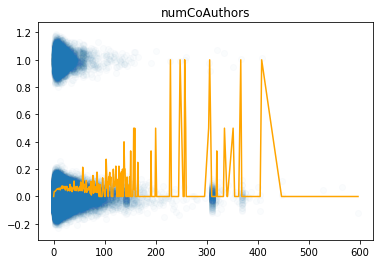

In [101]:
fig, ax = plt.subplots()
plot_feature(ax, authors, authors['hasRetraction'], 'numCoAuthors')

In [74]:
authors['coAuthors'] = expand_feature(
        df.loc[:, ['numAuthors','authors']].T.apply(
            lambda x: [[[y['ids'] for y in x.iloc[1]]]]*x.iloc[0]))

In [88]:
grpd_authors = authors.groupby('ids').first().reset_index()
coauthors = authors.groupby('ids')['coAuthors'].sum()
grpd_authors['coAuthors'] = coauthors.values

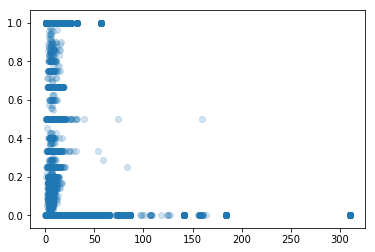

In [108]:
# plt.scatter(authors['numPapers'], authors['numRetractions'])
plt.scatter(authors['numCoAuthors']/authors['numPapers'], authors['numRetractions']/authors['numPapers'], alpha=0.2)

ids
-18                  [[3886054], [5401181], [], [4461581], []]
-17                  [[3886054], [5401181], [], [4461581], []]
-16                                                       [[]]
-15                                                       [[]]
-14                             [[4574651], [], [], [5313169]]
-13                             [[4574651], [], [], [5313169]]
-12          [[38693234], [], [39639367], [], [39814651], [...
-11          [[38693234], [], [39639367], [], [39814651], [...
-10                            [[], [], [3536323], [40616937]]
-9                             [[], [], [3536323], [40616937]]
-8                                  [[], [3591481], [1854447]]
-7                                             [[], [6265987]]
-6           [[5256228], [38459452], [1755336], [7259260], ...
-5           [[5256228], [38459452], [1755336], [7259260], ...
-4                                                        [[]]
-3                                            [[191

# DataCleaner Testing

In [4]:
from src.cleanup import DataCleaner, FeatureEngineer

In [5]:
cleaner = DataCleaner()

In [189]:
cleaner.fit(G)

In [ ]:
# sG = cleaner.transform(G)

In [9]:
cleaner.fit(X0.iloc[:20, :].loc[:, ['entities']])

# Graph Testing

# Papers
--------
### PAPER SCHEMA
    id: paper ID
    year: year published
    journal: publishing journal
    length: approx number of pages
    topics: list of associated topics
    authors: list of author ids
    in_citations: list of parent nodes
    out_citations: list of child nodes
    retracted: bool (True if retracted/withdrawn)
    
--------

### RELATIONS
    dist_common_ancestor: distance to closest common source if one exists
    dist_to_common_child: distance to closest common child if one exists
    dist_authors: minimum distance between authors
    avg_dist_authors: average distance between authors
    journal_similarity: similarity of journals
    topic_similarity: similarity of topics
---------
### OUTPUT METRICS
    influence: number of descendent nodes
    trust: function of author, journal, topic, and parent trusts
    risk: probability of retraction
---------

# Authors
--------
### SCHEMA
    id: author ID
    papers: list of authored works
    journals: list of publishing journals
    coauthors: list of coauthors
    topics: list of associated topics
    
    in_cited_authors: list of parent nodes
    out_cited_authors: list of child nodes
    retractions: list of retracted articles
    
--------
### RELATIONS
    child_dist: distance to common child
    source_dist: distance to common source
    coauthor_dist: distance in author space

    journal_similarity: cosine similarity of journals.
    topic_similarity: cosine similarity of authored topics.

---------
### OUTPUT METRICS
    influence: number of descendent nodes
    trust: function of retractions, papers, journals, topics, coauthor, and parent trusts
    
---------

In [55]:
import scipy.stats as stats

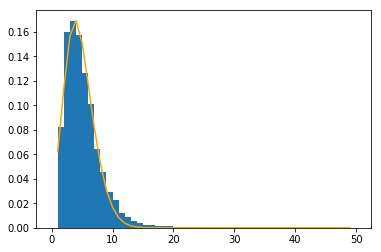

In [161]:
plt.hist(X['numAuthors'], bins=50, range=(0,50), density=True)
plt.plot(range(1,50), stats.skewnorm(loc=2, scale=3.5, a=2).pdf(range(1, 50)), c='orange')

In [114]:
stats.skewnorm.fit

In [156]:
X['numAuthors'].mean()

4.6775274782990675

In [173]:
n = stats.skewnorm(loc=2, scale=3.5, a=2).pdf(range(1, 50))
n.argmax()

3

/Users/alexklein/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


(324.07948416965496, 0.9082327721282661, 17.824980073572924)

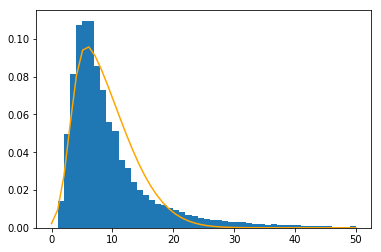

In [296]:
plt.hist(authors['numCoAuthors'], bins=50, range=(0,50), density=True)
plt.plot(np.linspace(0, 50), stats.skewnorm(loc=3, scale=7.5, a=5).pdf(np.linspace(0, 50)), c='orange')
stats.skewnorm.fit(authors['numCoAuthors'])
# 3.1969295476482187, -0.20217404085028115, 2.5716367541343006

In [251]:
authors['numCoAuthors']

0          3
1          3
2          0
3          0
4          2
5          2
6          4
7          4
8          2
9          2
10         2
11         1
12        57
13        57
14         0
15         1
16        17
17         4
18         4
19        88
20        76
21        19
22        10
23         3
24         9
25         5
26        24
27        15
28        13
29         3
          ..
333879     4
333880     7
333881     1
333882    18
333883     5
333884     5
333885     5
333886     4
333887     4
333888    14
333889     6
333890     5
333891     6
333892     8
333893     8
333894     8
333895     6
333896     4
333897     3
333898     4
333899     6
333900     4
333901     2
333902     2
333903     3
333904     5
333905     5
333906     5
333907     1
333908     6
Name: numCoAuthors, Length: 333909, dtype: int64

In [211]:
stats.skewnorm(loc=1.5, scale=1.5, a=14).pdf(np.linspace(0, 20))

array([2.51441033e-45, 4.46270614e-25, 4.21888070e-11, 2.64860032e-03,
       4.72708160e-01, 4.98449623e-01, 4.35447340e-01, 3.53259094e-01,
       2.66130407e-01, 1.86182596e-01, 1.20955912e-01, 7.29723879e-02,
       4.08821241e-02, 2.12692308e-02, 1.02757505e-02, 4.61018928e-03,
       1.92073477e-03, 7.43120902e-04, 2.66989998e-04, 8.90787154e-05,
       2.75991899e-05, 7.94076167e-06, 2.12163868e-06, 5.26409994e-07,
       1.21288678e-07, 2.59513430e-08, 5.15635547e-09, 9.51413473e-10,
       1.63019359e-10, 2.59389567e-11, 3.83273916e-12, 5.25907616e-13,
       6.70120791e-14, 7.92939701e-15, 8.71305930e-16, 8.89087723e-17,
       8.42484645e-18, 7.41349181e-19, 6.05796928e-20, 4.59700269e-21,
       3.23940976e-22, 2.11982716e-23, 1.28818564e-24, 7.26942222e-26,
       3.80947187e-27, 1.85384357e-28, 8.37770057e-30, 3.51576648e-31,
       1.37012012e-32, 4.95839027e-34])

In [273]:
np.histogram(authors['numCoAuthors'], 50, density=True)[0].mean()

0.0016750418760469012

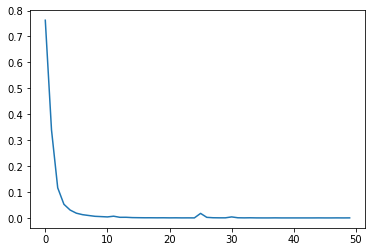

In [292]:
plt.plot(((lambda x: x[0] * x[1][1:])(np.histogram(authors['numCoAuthors'], 50, density=True))))

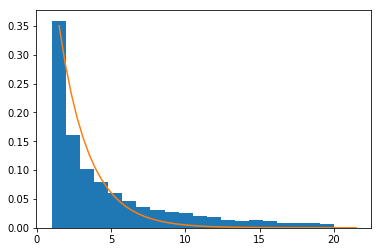

In [403]:
plt.hist(X.groupby('journalName')['entities'].count().sort_values()[-2:1:-1].values, range=(1,20), bins=20, density=True)
# plt.plot(np.linspace(0, 20), stats.norm(loc=1.5, scale=0.5).pdf(np.linspace(0, 20)), c='orange')
plt.plot(np.linspace(1.5, 21.5), 0.35 * np.exp(-(np.linspace(0,20))*.5))

In [344]:
X.groupby('journalName')['entities'].count().sort_values()[-2:1:-1].std()

40.85807562398943

# Database

In [7]:
import pymongo
import json
from pymongo import MongoClient
client = MongoClient()


In [8]:
db = client.papers

In [9]:
with open('data/s2-corpus-00') as f:
    for line in f:
        dct = json.loads(line) 
        db.posts.insert_one(document=dct)

In [6]:
client.list_database_names()

['admin', 'config', 'local']

In [12]:
dct = d.to_dict()

In [16]:
# X.sort_values(by='numInCitations', ascending=False)

,id,title,journalName,paperAbstract,inCitations,outCitations,numInCitations,authors,numAuthors,entities,numEntities,venue,sources,year,pageLength
62752,1c7f83bb11d144b753d9e847db2c74542ddba922,Probabilistic roadmaps for path planning in hi...,IEEE Trans. Robotics and Automation,Real-time robot motion planning using rasteriz...,"[2de760531be1777486d4ab993a7c5938eed5a88b, 44c...","[9a4d22c317233cc2104d4e7ed95400aeaef13d18, 467...",2352,"[{'name': 'Lydia E. Kavraki', 'ids': ['1780248...",4,"[Algorithm, Computer graphics, Directed graph,...",11,IEEE Trans. Robotics and Automation,[DBLP],1996.0,15.0
47850,031a119926c422a1190eb132b850bc25f6ece83a,Akt Promotes Cell Survival by Phosphorylating ...,Cell,Survival factors can suppress apoptosis in a t...,"[d930cb9447182956dcad3b892cdc61ca1a7985f0, 9e6...","[4356fd3cd742d7effc48e89b90fdfcbd9171a2db, 07e...",2106,"[{'name': 'Anne Brunet', 'ids': ['3125568']}, ...",10,"[14-3-3 Proteins, Apoptosis, Bad protein, Cell...",14,Cell,[Medline],1999.0,12.0
133068,28f7a13f36ba3d34f3b55536a6ffb39faf754474,Reversible middle cerebral artery occlusion wi...,Stroke,"To develop a simple, relatively noninvasive sm...","[d9e74b6157ca4a89426bfccab84550ca2c20bbfd, 204...","[ab315f118a38fbe77be3a6f1b69c2edbbe673032, 1ff...",1606,"[{'name': 'E Z Longa', 'ids': ['5691156']}, {'...",4,"[Analysis of arterial blood gases and pH, Bone...",25,Stroke,[Medline],1989.0,8.0
106149,8e93f461a5ffea470bff8174c49c219b1592eaf1,The neural basis of drug craving: an incentive...,Brain research. Brain research reviews,This paper presents a biopsychological theory ...,"[dc7465b2ebe7b795a716d59d4175bfa20225d1d1, f76...","[22e6c8bd39a22838f024ed47cc99fbeb5dd23a2d, ea9...",1581,"[{'name': 'T E Robinson', 'ids': ['1742043']},...",2,"[Addictive Behavior, Addresses (publication fo...",12,Brain research. Brain research reviews,[Medline],1993.0,45.0
150164,f833a6ff9e6a7bfac974542b8e20584bcc9a8fcd,Opposing effects of ERK and JNK-p38 MAP kinase...,Science,Apoptosis plays an important role during neuro...,"[439e7c7c0451c7685a0e8328dab943f0e9c2ef19, 886...",[],1496,"[{'name': 'Z Xia', 'ids': ['1763091']}, {'name...",5,"[Apoptosis, Cell Death, Growth Factor, Mitogen...",9,Science,[Medline],1995.0,6.0
82492,f6bd9b67e8e3689fe363a81f30e1b16e1d5eca27,A new and sensitive method for measuring therm...,Pain,A method to measure cutaneous hyperalgesia to ...,"[994ff1a04087f89735ebdd96effec991f01a0729, c37...",[],1351,"[{'name': 'K Hargreaves', 'ids': ['4651325']},...",5,"[Biological Assay, Carrageenan, Hyperalgesia, ...",9,Pain,[Medline],1988.0,12.0
173740,df473e1cbce6bbd51e2a0ba88fdafd7b1270b54c,Foundations of constraint satisfaction,,Preface Many problems can be formulated as Con...,"[1feec07303735714a28ef3eccd42b6883e1bcf2b, 1dd...",[],1292,"[{'name': 'Edward P. K. Tsang', 'ids': ['17746...",1,"[Algorithm, Artificial general intelligence, A...",12,Computation in cognitive science,[DBLP],1993.0,421.0
31277,13566e93089086ca60efcd45349a2c3c409a3878,Updated clinical classification of pulmonary h...,Journal of the American College of Cardiology,"In 1998, a clinical classification of pulmonar...","[196cc8c891462c416712f08a3e0748c85b3a2ff2, 3d4...","[86cbb83aa3537589d24f22830176997ca5c95672, 4f1...",1236,"[{'name': 'Gerald Simonneau', 'ids': ['4598504...",13,"[4-Aminohippuric Acid, Anemia, Anemia, Hemolyt...",15,Journal of the American College of Cardiology,[Medline],2009.0,12.0
71027,0c8b41428da1b55500c528df6d947bec0c8716ae,The development of QUADAS: a tool for the qual...,BMC Medical Research Methodology,BACKGROUND\nIn the era of evidence based medic...,"[3de94ac779a871d07b1056a0533a823323fdd078, 78d...","[bd3ecbe00b65a47397f65a300c059a3dbb1f7f77, 717...",1172,"[{'name': 'Penny Whiting', 'ids': ['2955973']}...",5,"[Patients, Progressive Disease, Reference Stan...",4,BMC medical research methodology,[Medline],2003.0,1.0
149211,62b3bf5e7b8c64a7ed0c172fbe0d3c77de9f77fe,A logic-based calculus of events,New Generation Computing,We outline an approach for reaso